In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from datetime import datetime, timedelta
import requests
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from pandas.io.json import json_normalize

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

In [3]:
cutoff_date = pd.to_datetime('2017-03-12')
time_interval = 365
start_date = cutoff_date - timedelta(days=time_interval)
years = [2016, 2017]

In [4]:
counter = 0
df = []

for year in years:
    url = 'https://nvd.nist.gov/feeds/json/cve/1.0/nvdcve-1.0-'+str(year)+'.json.zip'
    extract_target = 'nvdcve-1.0-'+str(year)+'.json'
    z = urlopen(url)
    stage_1 = z.read()
    stage_2 = (BytesIO(stage_1))
    stage_3 = ZipFile(stage_2)
    stage_4 = stage_3.extract(extract_target)
    yearly_data = pd.read_json(stage_4)
    if counter == 0:
        df = yearly_data
    else:
        df = df.append(yearly_data)
    counter +=1
    print(year)
    print('complete')

2016
complete
2017
complete


In [5]:
CVE_Items = json_normalize(df["CVE_Items"])

In [6]:
df = pd.concat([df.reset_index(), CVE_Items], axis=1)
df = df.drop(["index", "CVE_Items"], axis=1)

In [7]:
len(df["cve.CVE_data_meta.ID"].unique())

26067

In [8]:
df = df.rename(columns={"cve.CVE_data_meta.ID": "CVE ID"})
CVE_ID = df["CVE ID"]
df.drop(labels=["CVE ID"], axis=1,inplace = True)
df.insert(0, "CVE ID", CVE_ID)

In [9]:
len(df[df.isnull().any(axis=1)])

21452

In [10]:
len(df[df["impact.baseMetricV2.acInsufInfo"].isnull()])

21228

In [11]:
df = df.drop(["impact.baseMetricV2.acInsufInfo"], axis=1)

In [12]:
len(df[df.isnull().any(axis=1)])

3838

In [13]:
df[df.isnull().any(axis=1)].head()

,CVE ID,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,configurations.CVE_data_version,configurations.nodes,cve.CVE_data_meta.ASSIGNER,cve.affects.vendor.vendor_data,cve.data_format,cve.data_type,cve.data_version,cve.description.description_data,cve.problemtype.problemtype_data,cve.references.reference_data,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,lastModifiedDate,publishedDate
0,CVE-2016-0001,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
3,CVE-2016-0004,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
12,CVE-2016-0013,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
16,CVE-2016-0017,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
18,CVE-2016-0019,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The Remote Desktop P...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,AV:N/AC:M/Au:N/C:C/I:C/A:C,2.0,8.6,10.0,False,False,False,HIGH,NaN,HIGH,NETWORK,HIGH,8.1,HIGH,HIGH,HIGH,NONE,UNCHANGED,NONE,CVSS:3.0/AV:N/AC:H/PR:N/UI:N/S:U/C:H/I:H/A:H,3.0,2.2,5.9,2018-10-30T16:27Z,2016-01-13T05:59Z


In [14]:
df[df.isnull().any(axis=1)].iloc[0]["cve.description.description_data"]

[{'lang': 'en',
  'value': '** REJECT **  DO NOT USE THIS CANDIDATE NUMBER. ConsultIDs: none. Reason: The CNA or individual who requested this candidate did not associate it with any vulnerability during 2016. Notes: none.'}]

In [15]:
y = 0
for x in df["cve.description.description_data"]:
    if "REJECT" in (json_normalize(x)["value"])[0]:
        y+=1
    else:
        y
print(y)

2979


In [16]:
df = df.dropna(axis=0)

In [17]:
df["publishedDate"] = pd.to_datetime(df["publishedDate"])

In [19]:
df["cve.problemtype.problemtype_data"].head(1).values[0]

[{'description': [{'lang': 'en', 'value': 'CWE-119'}]}]

In [20]:
CWE_entry_1 = []
CWE_index = df["cve.problemtype.problemtype_data"].index
for x in df["cve.problemtype.problemtype_data"]:
    CWE_normalized_json_step_1 = json_normalize(x)
    CWE_normalized_json_step_2 = CWE_normalized_json_step_1["description"][0]
    raw_CWE_entry = json_normalize(CWE_normalized_json_step_2)["value"][0]
    clean_CWE_entry = str(raw_CWE_entry)
    CWE_entry_1.append(clean_CWE_entry)
    
CWE_entry_1 = pd.Series(CWE_entry_1, index = CWE_index)

In [21]:
CWE_entry_2 = []

for x in df["cve.problemtype.problemtype_data"]:
    try:
        CWE_normalized_json_step_1 = json_normalize(x)
        CWE_normalized_json_step_2 = CWE_normalized_json_step_1["description"][0]
        raw_CWE_entry = json_normalize(CWE_normalized_json_step_2)["value"][1]
        clean_CWE_entry = str(raw_CWE_entry)
        CWE_entry_2.append(clean_CWE_entry)
    
    except:
        CWE_entry_2.append("NONE")

CWE_entry_2 = pd.Series(CWE_entry_2, index = CWE_index)

In [22]:
df_CWE = pd.concat([CWE_entry_1, CWE_entry_2], axis=1)
df_CWE.columns = ["CWE Code 1", "CWE Code 2"]

In [23]:
CWE_entry_1.unique()

array(['CWE-119', 'CWE-20', 'CWE-264', 'CWE-200', 'CWE-79', 'CWE-426',
       'NVD-CWE-Other', 'CWE-255', 'CWE-19', 'CWE-254', 'CWE-284',
       'CWE-601', 'CWE-611', 'CWE-89', 'CWE-613', 'CWE-798', 'CWE-77',
       'CWE-399', 'CWE-352', 'CWE-78', 'CWE-532', 'NVD-CWE-noinfo',
       'CWE-434', 'CWE-502', 'CWE-285', 'CWE-275', 'CWE-384', 'CWE-310',
       'CWE-362', 'CWE-693', 'CWE-189', 'CWE-74', 'CWE-287', 'CWE-327',
       'CWE-416', 'CWE-94', 'CWE-295', 'CWE-22', 'CWE-88', 'CWE-347',
       'CWE-361', 'CWE-320', 'CWE-476', 'CWE-125', 'CWE-400', 'CWE-369',
       'CWE-388', 'CWE-17', 'CWE-326', 'CWE-190', 'CWE-191', 'CWE-338',
       'CWE-358', 'CWE-787', 'CWE-404', 'CWE-59', 'CWE-1', 'CWE-129',
       'CWE-16', 'CWE-407', 'CWE-538', 'CWE-824', 'CWE-118', 'CWE-444',
       'CWE-332', 'CWE-134', 'CWE-93', 'CWE-552', 'CWE-668', 'CWE-199',
       'CWE-918', 'CWE-417', 'CWE-297', 'CWE-345', 'CWE-415', 'CWE-306',
       'CWE-640', 'CWE-331', 'CWE-116', 'CWE-91', 'CWE-172', 'CWE-427',
    

In [24]:
CWE_entry_2.unique()

array(['NONE', 'CWE-284', 'CWE-254', 'CWE-200', 'CWE-362', 'CWE-264',
       'CWE-310', 'CWE-532', 'CWE-89', 'CWE-77', 'CWE-287', 'CWE-190',
       'CWE-326', 'CWE-416', 'CWE-476', 'CWE-434', 'CWE-22', 'CWE-255',
       'CWE-78', 'CWE-399', 'NVD-CWE-Other', 'CWE-787', 'CWE-20',
       'CWE-189', 'CWE-79', 'CWE-345', 'CWE-798', 'CWE-611', 'CWE-93',
       'CWE-125', 'CWE-285', 'NVD-CWE-noinfo', 'CWE-74', 'CWE-320',
       'CWE-749', 'CWE-59', 'CWE-191', 'CWE-94', 'CWE-388', 'CWE-415',
       'CWE-502', 'CWE-369', 'CWE-131', 'CWE-770', 'CWE-681', 'CWE-295',
       'CWE-617', 'CWE-755', 'CWE-835', 'CWE-400', 'CWE-426', 'CWE-772',
       'CWE-193', 'CWE-674', 'CWE-522', 'CWE-129', 'CWE-601', 'CWE-91',
       'CWE-347', 'CWE-918', 'CWE-922', 'CWE-346', 'CWE-521', 'CWE-311',
       'CWE-552', 'CWE-704', 'CWE-330', 'CWE-354', 'CWE-732'],
      dtype=object)

In [25]:
def consolidate_unknowns(x):
    if x == "NVD-CWE-Other" or x == "NVD-CWE-noinfo":
        return "UNKNOWN"
    else:
        return x

In [26]:
df_CWE = df_CWE.applymap(consolidate_unknowns)
CWE_entry_1 = CWE_entry_1.apply(consolidate_unknowns)
CWE_entry_2 = CWE_entry_2.apply(consolidate_unknowns)

In [27]:
df_w_CWE_codes = df.join(df_CWE)

In [28]:
df_w_CWE_codes.head()

,CVE ID,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,configurations.CVE_data_version,configurations.nodes,cve.CVE_data_meta.ASSIGNER,cve.affects.vendor.vendor_data,cve.data_format,cve.data_type,cve.data_version,cve.description.description_data,cve.problemtype.problemtype_data,cve.references.reference_data,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,lastModifiedDate,publishedDate,CWE Code 1,CWE Code 2
1,CVE-2016-0002,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,"[{'operator': 'AND', 'children': [{'operator':...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The Microsoft (1) VB...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,HIGH,NETWORK,NONE,COMPLETE,7.6,COMPLETE,COMPLETE,AV:N/AC:H/Au:N/C:C/I:C/A:C,2.0,4.9,10.0,False,False,False,HIGH,True,HIGH,NETWORK,HIGH,7.5,HIGH,HIGH,HIGH,NONE,UNCHANGED,REQUIRED,CVSS:3.0/AV:N/AC:H/PR:N/UI:R/S:U/C:H/I:H/A:H,3.0,1.6,5.9,2018-10-12T22:10Z,2016-01-13 05:59:00+00:00,CWE-119,NONE
2,CVE-2016-0003,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Microsoft Edge allow...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,AV:N/AC:M/Au:N/C:C/I:C/A:C,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,NETWORK,HIGH,9.6,CRITICAL,HIGH,HIGH,NONE,CHANGED,REQUIRED,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:C/C:H/I:H/A:H,3.0,2.8,6.0,2018-10-12T22:10Z,2016-01-13 05:59:00+00:00,CWE-119,NONE
4,CVE-2016-0005,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Microsoft Internet E...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,NONE,4.3,NONE,PARTIAL,AV:N/AC:M/Au:N/C:N/I:P/A:N,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,NETWORK,NONE,4.3,MEDIUM,NONE,LOW,NONE,UNCHANGED,REQUIRED,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:L/A:N,3.0,2.8,1.4,2018-10-12T22:10Z,2016-01-13 05:59:00+00:00,CWE-20,NONE
5,CVE-2016-0006,CVE,MITRE,4,10188,2019-10-11T08:00Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The sandbox implemen...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/798...,MEDIUM,LOCAL,NONE,COMPLETE,6.9,COMPLETE,COMPLETE,AV:L/AC:M/Au:N/C:C/I:C/A:C,2.0,3.4,10.0,False,False,False,MEDIUM,True,LOW,LOCAL,HIGH,7.3,HIGH,HIGH,

In [29]:
from bs4 import BeautifulSoup
import lxml.etree

In [30]:
NVD_CWE_description_url = requests.get("https://nvd.nist.gov/vuln/categories")
CWE_definitions_page_soup =  BeautifulSoup(NVD_CWE_description_url.content, "html5lib")
table = CWE_definitions_page_soup.find_all('table')[0] 
df_CWE_definitions = pd.read_html(str(table))[0]

In [31]:
df_CWE_definitions

,Name,CWE-ID,Description
0,CWE-843,Access of Resource Using Incompatible Type ('T...,The program allocates or initializes a resourc...
1,CWE-824,Access of Uninitialized Pointer,The program accesses or uses a pointer that ha...
2,CWE-770,Allocation of Resources Without Limits or Thro...,The software allocates a reusable resource or ...
3,CWE-670,Always-Incorrect Control Flow Implementation,The code contains a control flow path that doe...
4,CWE-294,Authentication Bypass by Capture-replay,A capture-replay flaw exists when the design o...
5,CWE-290,Authentication Bypass by Spoofing,This attack-focused weakness is caused by impr...
6,CWE-639,Authorization Bypass Through User-Controlled Key,The system's authorization functionality does ...
7,CWE-120,Buffer Copy without Checking Size of Input ('C...,The program copies an input buffer to an outpu...
8,CWE-312,Cleartext Storage of Sensitive Information,The application stores sensitive information i...
9,CWE-319,Cleartext Transmission of Sensitive Information,The software transmits sensitive or security-c...


In [32]:
df_w_CWE_defs = df_w_CWE_codes.merge(df_CWE_definitions, how="left", left_on= "CWE Code 1", right_on = "Name")

In [33]:
df_w_CWE_defs = df_w_CWE_defs.rename(columns={'CWE-ID': 'CWE Code 1 Name', 'Description': 'CWE Code 1 Description'})
df_w_CWE_defs = df_w_CWE_defs.drop(["Name"], axis=1)

In [34]:
df_w_CWE_defs = df_w_CWE_defs.merge(df_CWE_definitions, how="left", left_on= "CWE Code 2", right_on = "Name")

In [35]:
df_w_CWE_defs = df_w_CWE_defs.rename(columns={'CWE-ID': 'CWE Code 2 Name', 'Description': 'CWE Code 2 Description'})
df_w_CWE_defs = df_w_CWE_defs.drop(["Name"], axis=1)

In [36]:
df_w_CWE_defs_cleaned = df_w_CWE_defs.drop(["CVE_data_type", "CVE_data_format", "cve.affects.vendor.vendor_data", "cve.problemtype.problemtype_data", "cve.description.description_data", "cve.references.reference_data", "CVE_data_version", "CVE_data_numberOfCVEs", "impact.baseMetricV2.cvssV2.vectorString", "impact.baseMetricV3.cvssV3.vectorString", "CVE_data_timestamp", "configurations.CVE_data_version", "configurations.nodes", "cve.CVE_data_meta.ASSIGNER", "cve.data_format", "cve.data_type", "cve.data_version", "lastModifiedDate", "publishedDate"], axis=1)

In [37]:
df_w_CWE_defs_cleaned.head()

,CVE ID,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,CWE Code 1,CWE Code 2,CWE Code 1 Name,CWE Code 1 Description,CWE Code 2 Name,CWE Code 2 Description
0,CVE-2016-0002,HIGH,NETWORK,NONE,COMPLETE,7.6,COMPLETE,COMPLETE,2.0,4.9,10.0,False,False,False,HIGH,True,HIGH,NETWORK,HIGH,7.5,HIGH,HIGH,HIGH,NONE,UNCHANGED,REQUIRED,3.0,1.6,5.9,CWE-119,NONE,Improper Restriction of Operations within the ...,The software performs operations on a memory b...,NaN,NaN
1,CVE-2016-0003,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,NETWORK,HIGH,9.6,CRITICAL,HIGH,HIGH,NONE,CHANGED,REQUIRED,3.0,2.8,6.0,CWE-119,NONE,Improper Restriction of Operations within the ...,The software performs operations on a memory b...,NaN,NaN
2,CVE-2016-0005,MEDIUM,NETWORK,NONE,NONE,4.3,NONE,PARTIAL,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,NETWORK,NONE,4.3,MEDIUM,NONE,LOW,NONE,UNCHANGED,REQUIRED,3.0,2.8,1.4,CWE-20,NONE,Improper Input Validation,The product does not validate or incorrectly v...,NaN,NaN
3,CVE-2016-0006,MEDIUM,LOCAL,NONE,COMPLETE,6.9,COMPLETE,COMPLETE,2.0,3.4,10.0,False,False,False,MEDIUM,True,LOW,LOCAL,HIGH,7.3,HIGH,HIGH,HIGH,LOW,UNCHANGED,REQUIRED,3.0,1.3,5.9,CWE-264,NONE,NaN,NaN,NaN,NaN
4,CVE-2016-0007,MEDIUM,LOCAL,NONE,COMPLETE,6.9,COMPLETE,COMPLETE,2.0,3.4,10.0,False,False,False,MEDIUM,True,LOW,LOCAL,HIGH,7.8,HIGH,HIGH,HIGH,NONE,UNCHANGED,REQUIRED,3.0,1.8,5.9,CWE-264,NONE,NaN,NaN,NaN,NaN


In [38]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
%matplotlib inline

In [39]:
CWE_counts_1 = CWE_entry_1.value_counts().sort_values(axis=0, ascending=False)
CWE_counts_1

CWE-119    3401
UNKNOWN    2586
CWE-79     2168
CWE-200    2079
CWE-20     1708
CWE-125     884
CWE-264     705
CWE-89      623
CWE-284     571
CWE-416     463
           ... 
CWE-670       1
CWE-681       1
CWE-273       1
CWE-664       1
CWE-642       1
CWE-909       1
CWE-18        1
CWE-178       1
CWE-534       1
CWE-749       1
Length: 155, dtype: int64

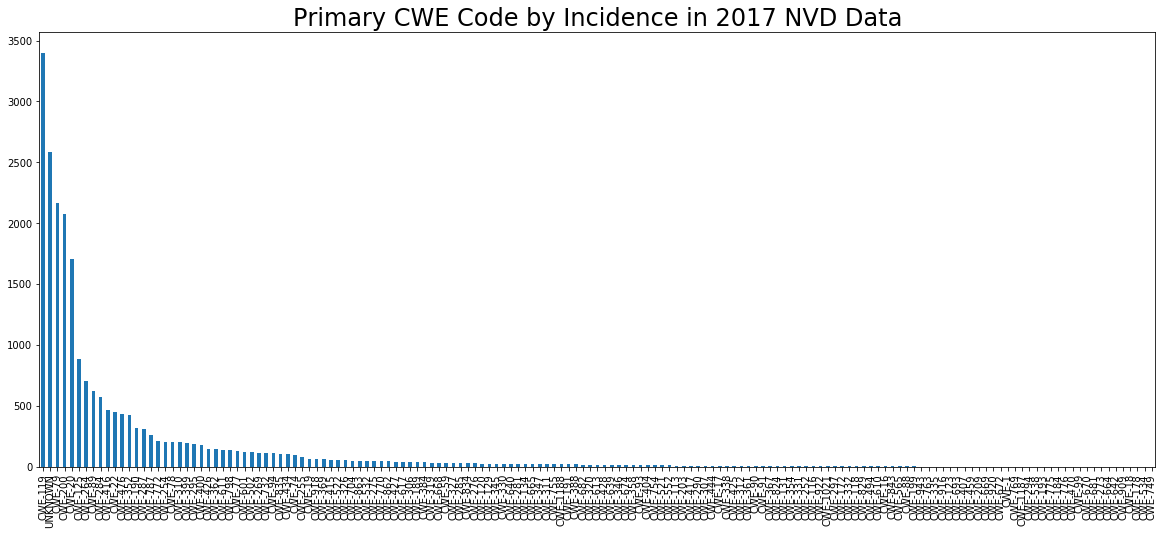

In [40]:
CWE_counts_1.plot(kind = "bar", figsize = (20,8))
plt.title("Primary CWE Code by Incidence in 2017 NVD Data", fontsize = 24)
plt.show();

In [41]:
CWE_119_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-119"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_119_info[0])
print(CWE_119_info[1])
print(CWE_119_info[2])

CWE-119
Improper Restriction of Operations within the Bounds of a Memory Buffer
The software performs operations on a memory buffer, but it can read from or write to a memory location that is outside of the intended boundary of the buffer.


In [42]:
CWE_counts_2 = CWE_entry_2.value_counts().sort_values(axis=0, ascending=False)
CWE_counts_2

NONE       21711
CWE-787       44
CWE-200       43
CWE-20        37
CWE-284       33
CWE-362       27
CWE-416       26
CWE-264       25
UNKNOWN       22
CWE-190       20
           ...  
CWE-674        1
CWE-74         1
CWE-94         1
CWE-521        1
CWE-552        1
CWE-131        1
CWE-749        1
CWE-285        1
CWE-345        1
CWE-191        1
Length: 68, dtype: int64

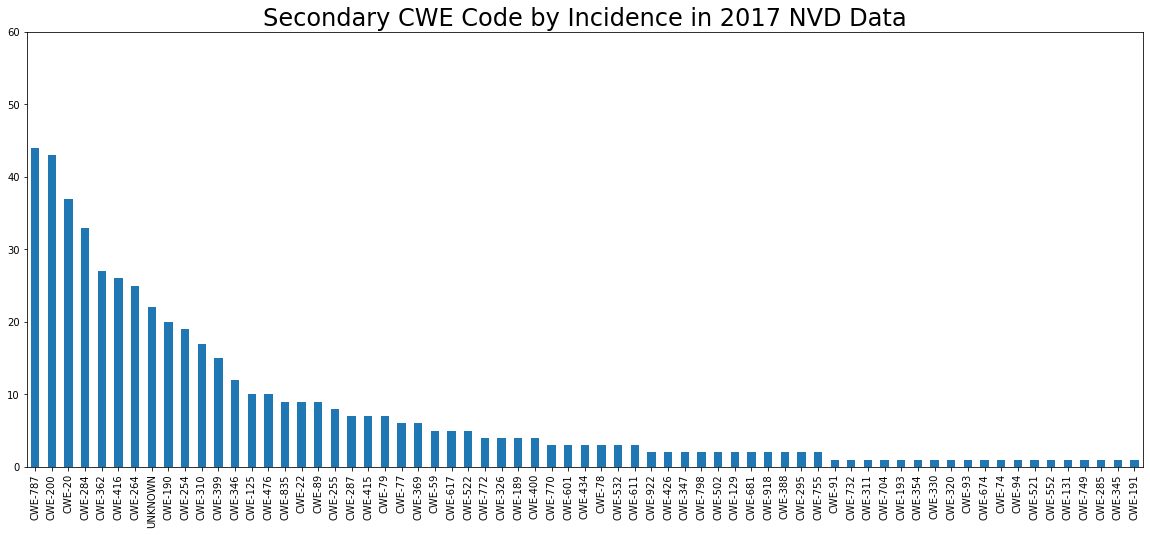

In [43]:
CWE_counts_2.drop("NONE").plot(kind = "bar", figsize = (20,8))
plt.title("Secondary CWE Code by Incidence in 2017 NVD Data", fontsize = 24)
plt.ylim(top=60)
plt.show();

In [44]:
CWE_200_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-200"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_200_info[0])
print(CWE_200_info[1])
print(CWE_200_info[2])

CWE-200
Information Exposure
An information exposure is the intentional or unintentional disclosure of information to an actor that is not explicitly authorized to have access to that information.


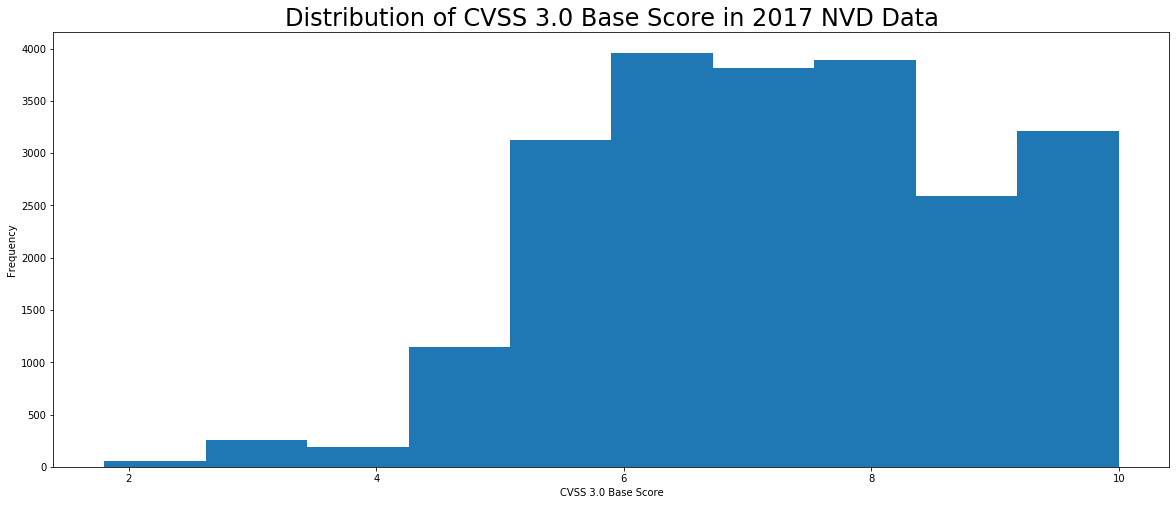

In [45]:
df_w_CWE_defs_cleaned["impact.baseMetricV3.cvssV3.baseScore"].plot(kind = "hist", figsize = (20,8))
plt.title("Distribution of CVSS 3.0 Base Score in 2017 NVD Data", fontsize = 24)
plt.xlabel('CVSS 3.0 Base Score');

In [46]:
CWE_1_count = df_w_CWE_defs_cleaned.groupby(["CWE Code 1"]).count()["CVE ID"].sort_values(ascending=False)

In [47]:
CWE_1_base = df_w_CWE_defs_cleaned.groupby(["CWE Code 1"]).mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

In [48]:
CWE_1_summary = pd.concat([CWE_1_count, CWE_1_base], axis=1, sort=True)

In [49]:
CWE_1_summary = CWE_1_summary.rename(columns={'CVE ID': 'Count', 'impact.baseMetricV3.cvssV3.baseScore': 'CVSS 3.0 Score'})

In [50]:
CWE_1_summary = CWE_1_summary.sort_values(by=['Count'], ascending=False)

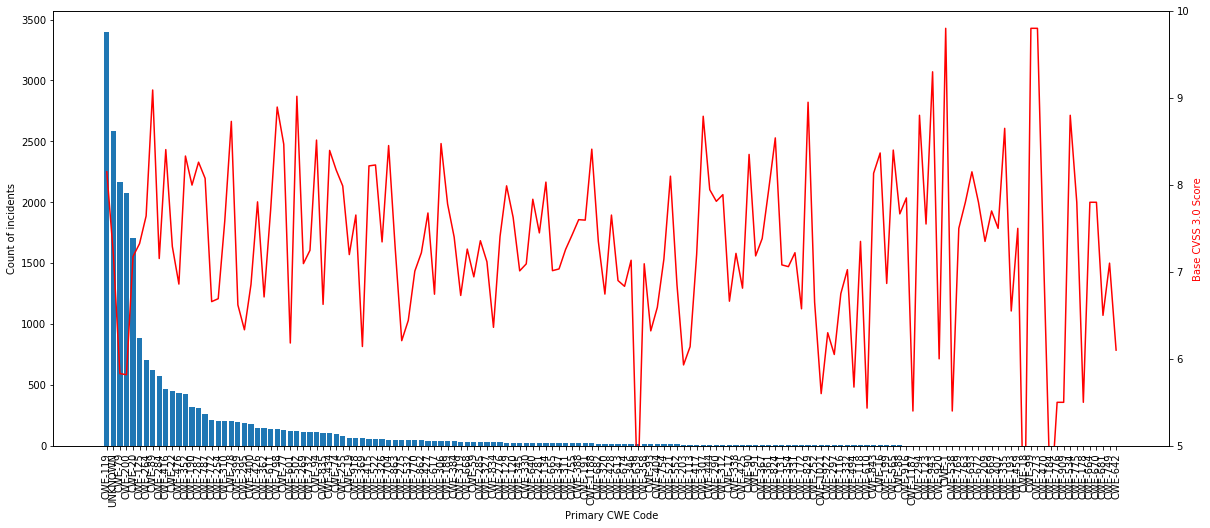

In [51]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax2 = ax1.twinx()
ax1.bar(CWE_1_summary.index, CWE_1_summary["Count"])
ax2.plot(CWE_1_summary.index, CWE_1_summary["CVSS 3.0 Score"], 'red')

ax1.set_xlabel('Primary CWE Code')
ax1.set_ylabel('Count of incidents')
ax2.set_ylabel('Base CVSS 3.0 Score', color='red')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

In [52]:
CWE_2_count = df_w_CWE_defs_cleaned.groupby(["CWE Code 2"]).count()["CVE ID"].sort_values(ascending=False)

In [53]:
CWE_2_base_CVSS = df_w_CWE_defs_cleaned.groupby(["CWE Code 2"]).mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

In [54]:
CWE_2_summary = pd.concat([CWE_2_count, CWE_2_base_CVSS], axis=1, sort=True)

In [55]:
CWE_2_summary = CWE_2_summary.rename(columns={'CVE ID': 'Count', 'impact.baseMetricV3.cvssV3.baseScore': 'CVSS 3.0 Score'})

In [56]:
CWE_2_summary = CWE_2_summary.sort_values(by=['Count'], ascending=False)

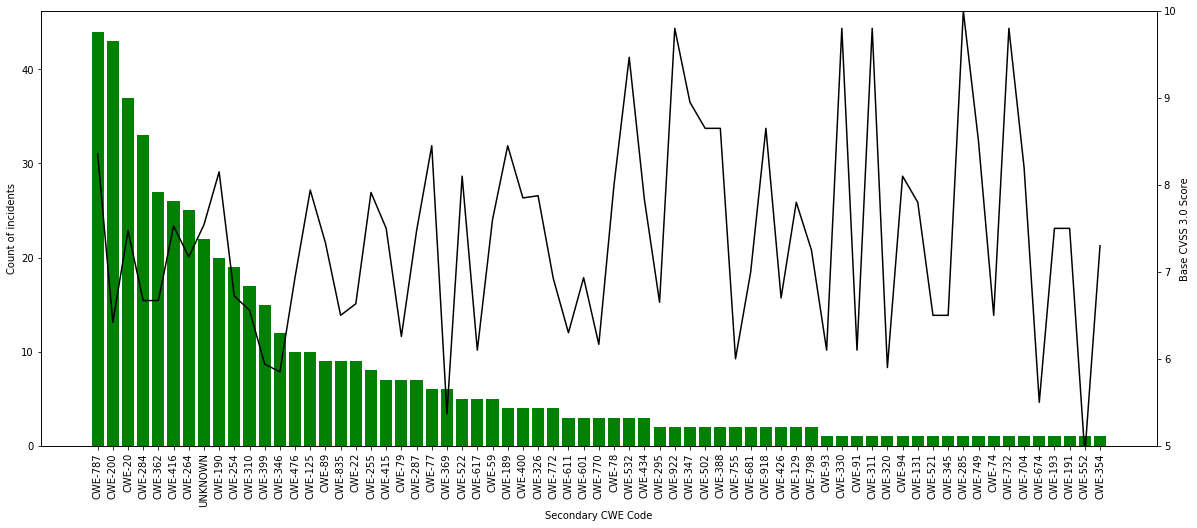

In [57]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax2 = ax1.twinx()
ax1.bar(CWE_2_summary.drop("NONE").index, CWE_2_summary.drop("NONE")["Count"], color ='green')
ax2.plot(CWE_2_summary.drop("NONE").index, CWE_2_summary.drop("NONE")["CVSS 3.0 Score"], color = 'black')

ax1.set_xlabel('Secondary CWE Code')
ax1.set_ylabel('Count of incidents')
ax2.set_ylabel('Base CVSS 3.0 Score')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

In [58]:
df_incident_counts = ((df_w_CWE_defs_cleaned.groupby("CWE Code 1").count())["CVE ID"]).to_frame()

In [59]:
df_incident_counts = df_incident_counts.rename(columns={"CVE ID": "CWE Count"})

In [60]:
df_w_CWE_defs_counts = df_w_CWE_defs_cleaned.merge(df_incident_counts, how="left", on="CWE Code 1")

In [61]:
df_sig_CWE = df_w_CWE_defs_counts[df_w_CWE_defs_counts["CWE Count"]>99]

In [62]:
df_sig_CWE.groupby("CWE Code 1").mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

CWE Code 1
CWE-89     9.090851
CWE-502    9.018487
CWE-798    8.894776
CWE-78     8.729902
CWE-94     8.515044
CWE-77     8.467460
CWE-416    8.405616
CWE-434    8.396154
CWE-352    8.331616
CWE-287    8.260897
             ...   
CWE-400    6.855056
CWE-362    6.711565
CWE-254    6.691262
CWE-772    6.657692
CWE-835    6.626168
CWE-399    6.619697
CWE-295    6.333862
CWE-601    6.181667
CWE-79     5.830028
CWE-200    5.817508
Name: impact.baseMetricV3.cvssV3.baseScore, Length: 35, dtype: float64

In [63]:
CWE_416_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-416"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_416_info[0])
print(CWE_416_info[1])
print(CWE_416_info[2])

CWE-416
Use After Free
Referencing memory after it has been freed can cause a program to crash, use unexpected values, or execute code.


In [64]:
CWE_89_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-89"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_89_info[0])
print(CWE_89_info[1])
print(CWE_89_info[2])

CWE-89
Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection')
The software constructs all or part of an SQL command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended SQL command when it is sent to a downstream component.


In [65]:
from sklearn.cluster import KMeans

In [66]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [67]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [68]:
feature_analysis = df_w_CWE_defs_cleaned.drop(["CVE ID","CWE Code 1 Name",
                                               "CWE Code 2 Name",
                                               "CWE Code 1 Description",
                                               "CWE Code 2 Description",
                                               "impact.baseMetricV2.cvssV2.accessComplexity",
                                               "impact.baseMetricV2.cvssV2.accessVector",
                                               "impact.baseMetricV2.cvssV2.authentication",
                                               "impact.baseMetricV2.cvssV2.availabilityImpact",
                                               "impact.baseMetricV2.cvssV2.baseScore",
                                               "impact.baseMetricV2.cvssV2.confidentialityImpact",
                                               "impact.baseMetricV2.cvssV2.integrityImpact",
                                               "impact.baseMetricV2.cvssV2.version",
                                               "impact.baseMetricV2.exploitabilityScore",
                                               "impact.baseMetricV2.impactScore",
                                               "impact.baseMetricV2.obtainAllPrivilege",
                                               "impact.baseMetricV2.obtainOtherPrivilege",
                                               "impact.baseMetricV2.obtainUserPrivilege",
                                               "impact.baseMetricV2.severity",
                                               "impact.baseMetricV2.userInteractionRequired",
                                               "impact.baseMetricV3.cvssV3.version"], axis=1)

In [69]:
feature_analysis = pd.get_dummies(feature_analysis)

In [ ]:
feature_analysis = feature_analysis.apply(pd.to_numeric, errors='coerce')

In [ ]:
feature_analysis.head()

In [ ]:
possible_k_values = range(2, 11, 1)

errors_per_k = [clustering_errors(k, feature_analysis) for k in possible_k_values]

In [ ]:
list(zip(possible_k_values, errors_per_k))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)
plt.title("Usefulness of Various Cluster Numbers in Analyzing 2017 NVD Data", fontsize = 24)

xticks = np.arange(min(possible_k_values), max(possible_k_values)+2, 1)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [ ]:
kmeans_6 = KMeans(n_clusters = 6, random_state = 42)
predictions_clusters = kmeans_6.fit_predict(feature_analysis)

In [ ]:
np.unique(predictions_clusters, return_counts=True)

In [ ]:
feature_analysis = feature_analysis.apply(pd.to_numeric, errors='coerce')

In [71]:
feature_analysis.head()

,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,impact.baseMetricV3.cvssV3.attackComplexity_HIGH,impact.baseMetricV3.cvssV3.attackComplexity_LOW,impact.baseMetricV3.cvssV3.attackVector_ADJACENT_NETWORK,impact.baseMetricV3.cvssV3.attackVector_LOCAL,impact.baseMetricV3.cvssV3.attackVector_NETWORK,impact.baseMetricV3.cvssV3.attackVector_PHYSICAL,impact.baseMetricV3.cvssV3.availabilityImpact_HIGH,impact.baseMetricV3.cvssV3.availabilityImpact_LOW,impact.baseMetricV3.cvssV3.availabilityImpact_NONE,impact.baseMetricV3.cvssV3.baseSeverity_CRITICAL,impact.baseMetricV3.cvssV3.baseSeverity_HIGH,impact.baseMetricV3.cvssV3.baseSeverity_LOW,impact.baseMetricV3.cvssV3.baseSeverity_MEDIUM,impact.baseMetricV3.cvssV3.confidentialityImpact_HIGH,impact.baseMetricV3.cvssV3.confidentialityImpact_LOW,impact.baseMetricV3.cvssV3.confidentialityImpact_NONE,impact.baseMetricV3.cvssV3.integrityImpact_HIGH,impact.baseMetricV3.cvssV3.integrityImpact_LOW,impact.baseMetricV3.cvssV3.integrityImpact_NONE,impact.baseMetricV3.cvssV3.privilegesRequired_HIGH,impact.baseMetricV3.cvssV3.privilegesRequired_LOW,impact.baseMetricV3.cvssV3.privilegesRequired_NONE,impact.baseMetricV3.cvssV3.scope_CHANGED,impact.baseMetricV3.cvssV3.scope_UNCHANGED,impact.baseMetricV3.cvssV3.userInteraction_NONE,impact.baseMetricV3.cvssV3.userInteraction_REQUIRED,CWE Code 1_CWE-1,CWE Code 1_CWE-1021,CWE Code 1_CWE-113,CWE Code 1_CWE-116,CWE Code 1_CWE-118,CWE Code 1_CWE-1187,CWE Code 1_CWE-1188,CWE Code 1_CWE-119,CWE Code 1_CWE-120,CWE Code 1_CWE-123,CWE Code 1_CWE-125,CWE Code 1_CWE-129,CWE Code 1_CWE-131,CWE Code 1_CWE-134,CWE Code 1_CWE-16,CWE Code 1_CWE-17,CWE Code 1_CWE-172,CWE Code 1_CWE-178,CWE Code 1_CWE-18,CWE Code 1_CWE-184,CWE Code 1_CWE-189,...,CWE Code 2_CWE-311,CWE Code 2_CWE-320,CWE Code 2_CWE-326,CWE Code 2_CWE-330,CWE Code 2_CWE-345,CWE Code 2_CWE-346,CWE Code 2_CWE-347,CWE Code 2_CWE-354,CWE Code 2_CWE-362,CWE Code 2_CWE-369,CWE Code 2_CWE-388,CWE Code 2_CWE-399,CWE Code 2_CWE-400,CWE Code 2_CWE-415,CWE Code 2_CWE-416,CWE Code 2_CWE-426,CWE Code 2_CWE-434,CWE Code 2_CWE-476,CWE Code 2_CWE-502,CWE Code 2_CWE-521,CWE Code 2_CWE-522,CWE Code 2_CWE-532,CWE Code 2_CWE-552,CWE Code 2_CWE-59,CWE Code 2_CWE-601,CWE Code 2_CWE-611,CWE Code 2_CWE-617,CWE Code 2_CWE-674,CWE Code 2_CWE-681,CWE Code 2_CWE-704,CWE Code 2_CWE-732,CWE Code 2_CWE-74,CWE Code 2_CWE-749,CWE Code 2_CWE-755,CWE Code 2_CWE-77,CWE Code 2_CWE-770,CWE Code 2_CWE-772,CWE Code 2_CWE-78,CWE Code 2_CWE-787,CWE Code 2_CWE-79,CWE Code 2_CWE-798,CWE Code 2_CWE-835,CWE Code 2_CWE-89,CWE Code 2_CWE-91,CWE Code 2_CWE-918,CWE Code 2_CWE-922,CWE Code 2_CWE-93,CWE Code 2_CWE-94,CWE Code 2_NONE,CWE Code 2_UNKNOWN
0,7.5,1.6,5.9,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,9.6,2.8,6.0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4.3,2.8,1.4,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,7.3,1.3,5.9,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,7.8,1.8,5.9,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [72]:
possible_k_values = range(2, 11, 1)

errors_per_k = [clustering_errors(k, feature_analysis) for k in possible_k_values]

In [73]:
list(zip(possible_k_values, errors_per_k))

[(2, 0.36429352497786804),
 (3, 0.316165952619334),
 (4, 0.2995242873338787),
 (5, 0.3290129389633897),
 (6, 0.35637713113495223),
 (7, 0.3317395822365543),
 (8, 0.3328187814281804),
 (9, 0.3364369836626469),
 (10, 0.34650421858682534)]

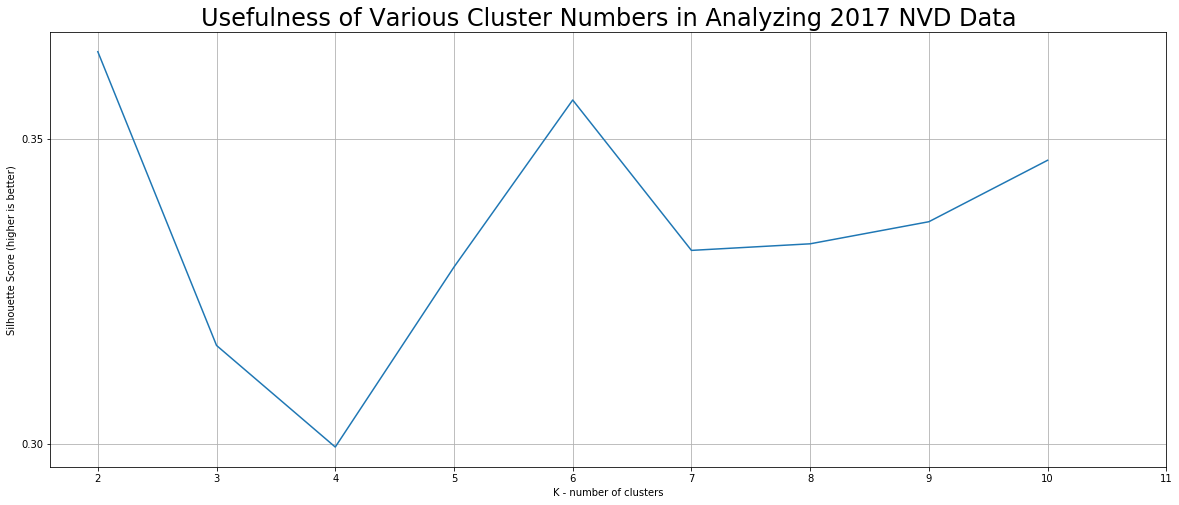

In [74]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)
plt.title("Usefulness of Various Cluster Numbers in Analyzing 2017 NVD Data", fontsize = 24)

xticks = np.arange(min(possible_k_values), max(possible_k_values)+2, 1)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [75]:
predictions_clusters = predictions_clusters + 1

In [78]:
predictions_clusters = predictions_clusters + 1

In [79]:
df_predicted_clusters = pd.DataFrame(predictions_clusters)
df_predicted_clusters = df_predicted_clusters.rename(columns={0: "Cluster"})

In [80]:
df_predicted_clusters["Cluster"].value_counts().sort_index()

1    7322
2    4386
3    2939
4    3365
5    2524
6    1693
Name: Cluster, dtype: int64

In [81]:
df_CWE_clusters = df_w_CWE_defs_cleaned.join(pd.DataFrame(df_predicted_clusters))

In [82]:
df_CWE_base_CVSS = df_CWE_clusters.groupby("Cluster").mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

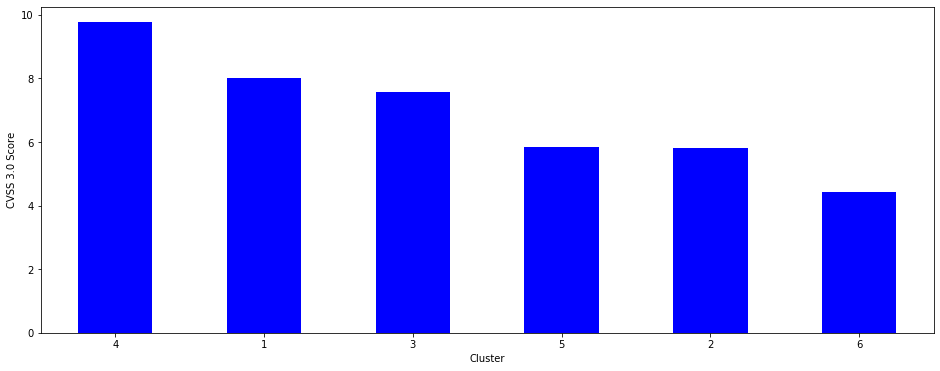

In [83]:
fig = df_CWE_base_CVSS.plot(kind="bar", figsize = (16,6), color = "b")
fig.set_ylabel('CVSS 3.0 Score');

for tick in fig.get_xticklabels():
    tick.set_rotation(0)

In [84]:
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
colors_clusters

[1, 2, 3, 4, 5, 6]

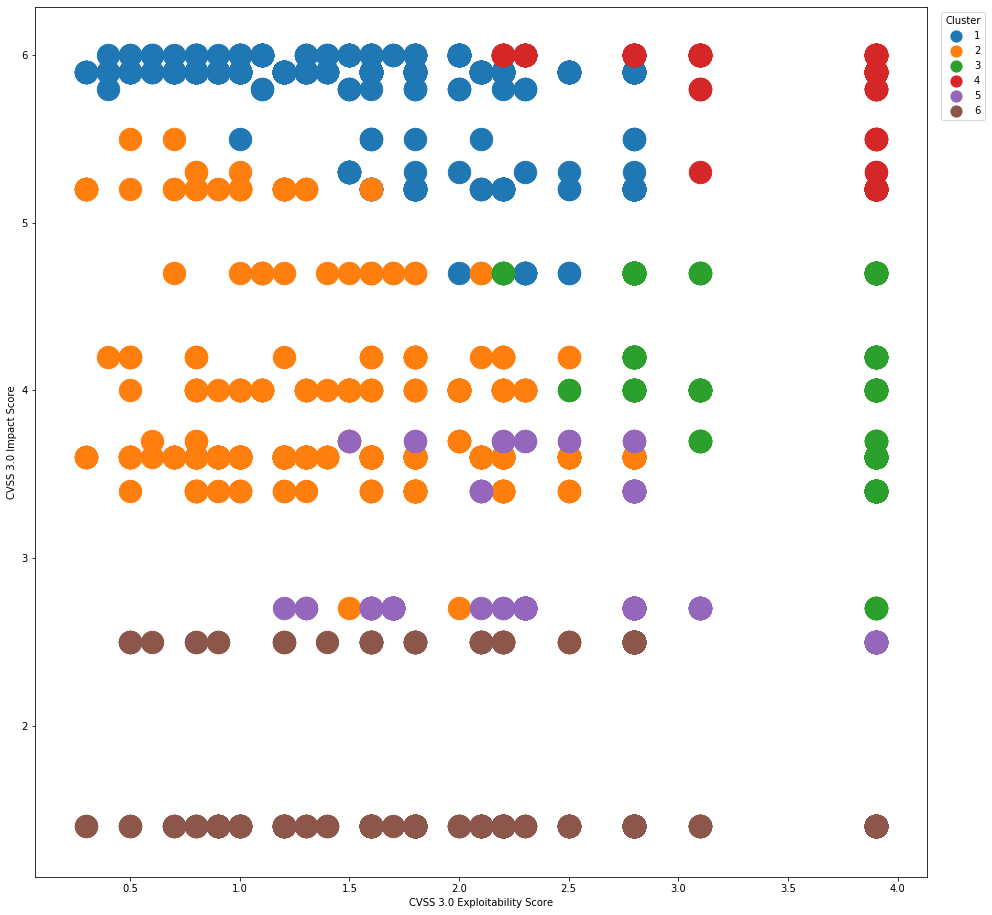

In [85]:
plt.figure(figsize=(16, 16))
plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 500, data = data, label = colors_clusters[i])

leg = plt.legend(markerscale = 0.5, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.show()

In [86]:
def rand_jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

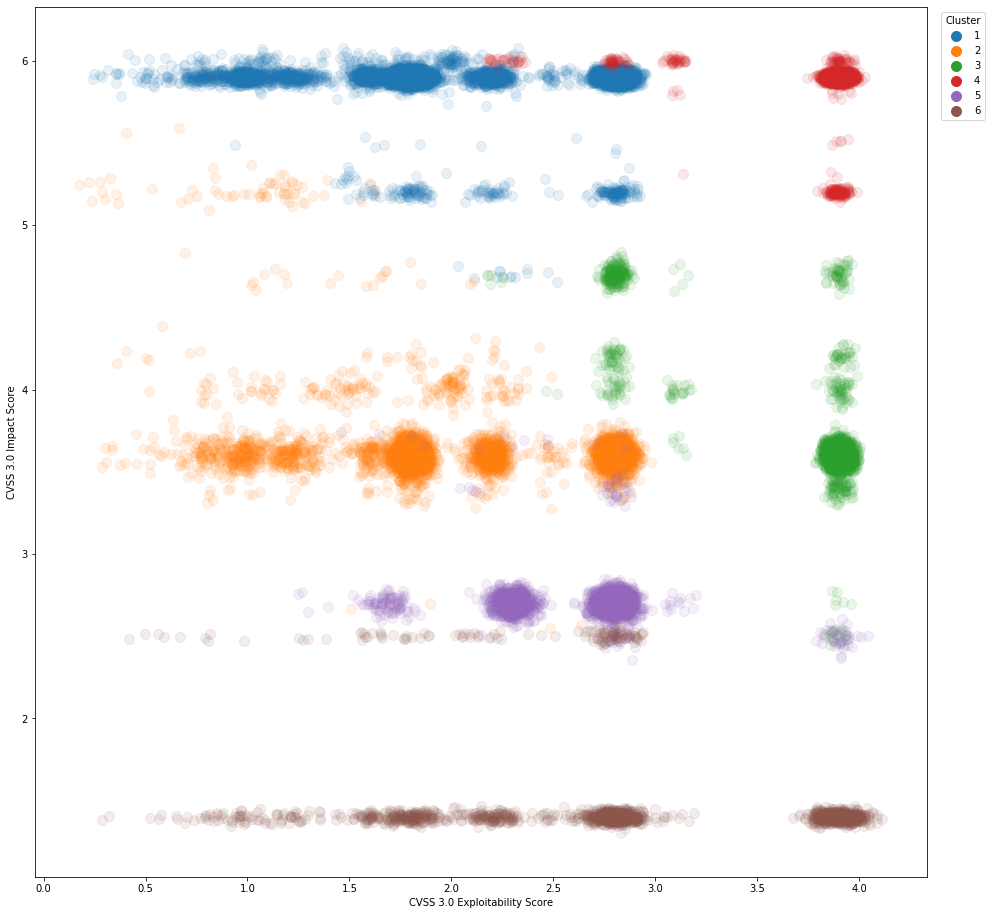

In [87]:
plt.figure(figsize=(16, 16))
plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    data["impact.baseMetricV3.exploitabilityScore"] = rand_jitter(data["impact.baseMetricV3.exploitabilityScore"])
    data["impact.baseMetricV3.impactScore"] = rand_jitter(data["impact.baseMetricV3.impactScore"])
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 100, alpha = 0.1, cmap = "set1", data=data, label=colors_clusters[i])

leg = plt.legend(markerscale = 1, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles:
    lh.set_alpha(1)
    
plt.show()

In [88]:
CVE_Equifax = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CVE ID"]=="CVE-2017-5638"]
CVE_Equifax

,CVE ID,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,CWE Code 1,CWE Code 2,CWE Code 1 Name,CWE Code 1 Description,CWE Code 2 Name,CWE Code 2 Description
18536,CVE-2017-5638,LOW,NETWORK,NONE,COMPLETE,10.0,COMPLETE,COMPLETE,2.0,10.0,10.0,False,False,False,HIGH,False,LOW,NETWORK,HIGH,10.0,CRITICAL,HIGH,HIGH,NONE,CHANGED,NONE,3.0,3.9,6.0,CWE-20,NONE,Improper Input Validation,The product does not validate or incorrectly v...,NaN,NaN


In [89]:
CWE_Equifax = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-20"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_Equifax[0])
print(CWE_Equifax[1])
print(CWE_Equifax[2])

CWE-20
Improper Input Validation
The product does not validate or incorrectly validates input that can affect the control flow or data flow of a program.


In [90]:
df_CWE_clusters[df_CWE_clusters["CVE ID"]=="CVE-2017-5638"]["Cluster"]

18536    4
Name: Cluster, dtype: int32

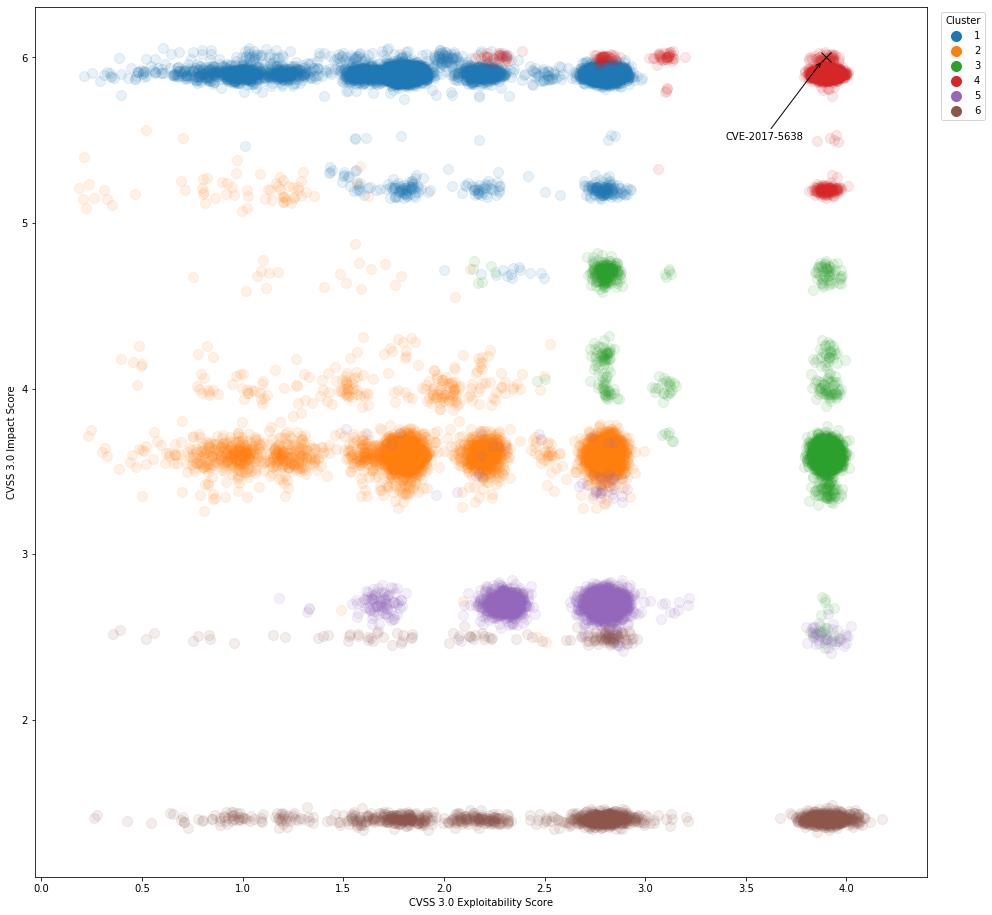

In [91]:
plt.figure(figsize=(16, 16))

plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')

cluster_colors = list(np.sort(df_CWE_clusters['Cluster'].unique()))

for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    data["impact.baseMetricV3.exploitabilityScore"] = rand_jitter(data["impact.baseMetricV3.exploitabilityScore"])
    data["impact.baseMetricV3.impactScore"] = rand_jitter(data["impact.baseMetricV3.impactScore"])
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 100, alpha = 0.1, cmap = "tab30", data=data, label=colors_clusters[i])

leg = plt.legend(markerscale = 1, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)

Equifax_X = CVE_Equifax["impact.baseMetricV3.exploitabilityScore"]
Equifax_Y = CVE_Equifax["impact.baseMetricV3.impactScore"]

plt.plot(Equifax_X, Equifax_Y, marker='x', markersize=10, color="black")
plt.annotate("CVE-2017-5638", color = "black", xy=(Equifax_X-.02, Equifax_Y-.02), xytext=(Equifax_X-.5, Equifax_Y-.5), arrowprops=dict(edgecolor="black", arrowstyle="->"))

plt.show();